In [102]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [103]:
import pandas as pd

df = pd.read_csv('USD_PLN Historical Data.csv', usecols=['Date', 'Price', 'Open', 'High', 'Low'])


In [104]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# wybór kolumny z danymi, które będą używane do predykcji
target_col = 'Price'

# skalowanie danych do zakresu 0-1
scaler = MinMaxScaler()
df[target_col] = scaler.fit_transform(df[target_col].values.reshape(-1, 1))

# podział danych na zbiór treningowy i testowy
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

# funkcja pomocnicza do tworzenia sekwencji czasowych
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# tworzenie sekwencji czasowych
time_steps = 10

X_train, y_train = create_sequences(train_df[['Price', 'Open', 'High', 'Low']], train_df[target_col], time_steps)
X_test, y_test = create_sequences(test_df[['Price', 'Open', 'High', 'Low']], test_df[target_col], time_steps)

print(f'Treningowe dane wejściowe i wyjściowe: {X_train.shape}, {y_train.shape}')
print(f'Testowe dane wejściowe i wyjściowe: {X_test.shape}, {y_test.shape}')


Treningowe dane wejściowe i wyjściowe: (1719, 10, 4), (1719,)
Testowe dane wejściowe i wyjściowe: (423, 10, 4), (423,)


In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(units=256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.1),
    LSTM(units=128, return_sequences=True),
    Dropout(0.1),
    LSTM(units=128, return_sequences=True),
    Dropout(0.1),
    LSTM(units=64),
    Dropout(0.1),
    Dense(units=1)
])

model.compile(loss='mse', optimizer='adam', run_eagerly=True)
model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 10, 256)           267264    
                                                                 
 dropout_49 (Dropout)        (None, 10, 256)           0         
                                                                 
 lstm_50 (LSTM)              (None, 10, 128)           197120    
                                                                 
 dropout_50 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_51 (LSTM)              (None, 10, 128)           131584    
                                                                 
 dropout_51 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_52 (LSTM)              (None, 64)              

In [106]:
history = model.fit(
    X_train, y_train,
    epochs=110,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)


Epoch 1/110
49/49 [==============================] - 13s 265ms/step - loss: 0.0211 - val_loss: 0.0847
Epoch 2/110
49/49 [==============================] - 13s 264ms/step - loss: 0.0489 - val_loss: 0.0942
Epoch 3/110
49/49 [==============================] - 12s 240ms/step - loss: 0.0668 - val_loss: 0.0646
Epoch 4/110
49/49 [==============================] - 12s 240ms/step - loss: 0.0565 - val_loss: 0.0912
Epoch 5/110
49/49 [==============================] - 12s 237ms/step - loss: 0.0537 - val_loss: 0.0834
Epoch 6/110
49/49 [==============================] - 12s 240ms/step - loss: 0.0555 - val_loss: 0.0811
Epoch 7/110
49/49 [==============================] - 12s 237ms/step - loss: 0.0562 - val_loss: 0.0651
Epoch 8/110
49/49 [==============================] - 12s 238ms/step - loss: 0.0575 - val_loss: 0.0386
Epoch 9/110
49/49 [==============================] - 12s 238ms/step - loss: 0.0539 - val_loss: 0.0247
Epoch 10/110
49/49 [==============================] - 12s 238ms/step - loss: 0.049

In [107]:
model.save('model.h5')


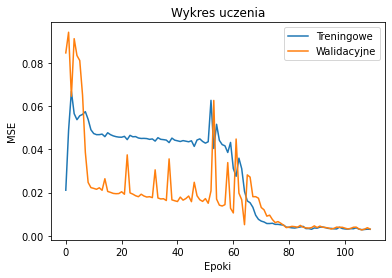

In [108]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Treningowe')
plt.plot(history.history['val_loss'], label='Walidacyjne')
plt.title('Wykres uczenia')
plt.xlabel('Epoki')
plt.ylabel('MSE')
plt.legend()
plt.show()


14/14 [==============================] - 1s 89ms/step


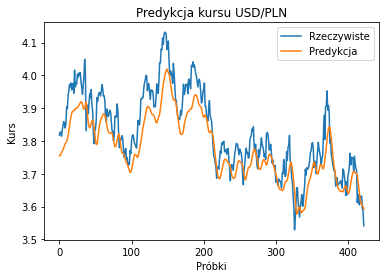

In [109]:
y_pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred)

plt.plot(y_test, label='Rzeczywiste')
plt.plot(y_pred, label='Predykcja')
plt.title('Predykcja kursu USD/PLN')
plt.xlabel('Próbki')
plt.ylabel('Kurs')
plt.legend()
plt.show()

In [110]:
df2 = pd.read_csv('USD_PLN Historical Data.csv', usecols=['Date', 'Price', 'Open', 'High', 'Low'])

In [111]:
from keras.models import load_model

model = load_model('model.h5')


In [112]:
import datetime
import pandas as pd

# Konwertowanie kolumny 'Date' na obiekt datetime
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values(by='Date', ascending=False)

# Tworzenie sekwencji czasowych
time_stepsp = 10
X, y = create_sequences(df2[['Price', 'Open', 'High', 'Low']], df2['Price'], time_steps)
print("Ostatnie 30 dni, na których opieramy predykcję:\n", df2[['Date', 'Price', 'Open', 'High', 'Low']].head(time_stepsp))

# Skalowanie danych
scaler = MinMaxScaler()
df2['Price'] = scaler.fit_transform(df2['Price'].values.reshape(-1, 1))

# Tworzenie sekwencji czasowych
time_steps = 10
X, y = create_sequences(df2[['Price', 'Open', 'High', 'Low']], df2['Price'], time_steps)

# Wczytanie modelu
model = load_model('model.h5')

# Przewidywanie cen na kolejne 7 dni
predictions = []
current_sequence = X[-1]
for i in range(7):
    current_sequence = current_sequence.reshape(1, time_steps, 4)
    next_prediction = model.predict(current_sequence)
    last_date = df2['Date'].max()
    next_date = last_date + datetime.timedelta(days=1)
    predictions.append((next_date, next_prediction[0, 0]))
    new_prediction = np.array([[next_prediction[0, 0], 0, 0, 0]]).reshape(1, 1, 4)
    current_sequence = np.concatenate([current_sequence[:, 1:, :], new_prediction], axis=1)

# Odwrócenie skali i wyświetlenie wyników
predictions = scaler.inverse_transform(np.array(predictions)[:, 1].reshape(-1, 1))
date_range = pd.date_range(start=df2['Date'].max(), periods=7, freq='D')
predictions_with_dates = pd.DataFrame({'Date': date_range, 'Price': predictions.flatten()})
print("\nPrzewidywane ceny na najbliższe 7 dni:\n", predictions_with_dates)


Ostatnie 30 dni, na których opieramy predykcję:
         Date   Price    Open    High     Low
0 2023-04-14  4.2185  4.1950  4.2320  4.1834
1 2023-04-13  4.1933  4.2320  4.2396  4.1901
2 2023-04-12  4.2308  4.2769  4.2818  4.2280
3 2023-04-11  4.2752  4.3178  4.3197  4.2695
4 2023-04-10  4.3138  4.2847  4.3302  4.2845
5 2023-04-07  4.2811  4.2909  4.3039  4.2814
6 2023-04-06  4.2870  4.2956  4.3095  4.2819
7 2023-04-05  4.2918  4.2701  4.3064  4.2623
8 2023-04-04  4.2665  4.2867  4.2975  4.2625
9 2023-04-03  4.2841  4.3163  4.3436  4.2832
1/1 [==============================] - 0s 23ms/step

Przewidywane ceny na najbliższe 7 dni:
         Date     Price
0 2023-04-14  3.592625
1 2023-04-15  3.501425
2 2023-04-16  3.334928
3 2023-04-17  3.113931
4 2023-04-18  2.842176
5 2023-04-19  2.518798
6 2023-04-20  2.158005


1/1 [==============================] - 0s 22ms/step


C:\Users\mreliga\AppData\Local\Temp\ipykernel_22572\2966324061.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_data['Price'] = scaler.inverse_transform(historical_data['Price'].values.reshape(-1, 1))


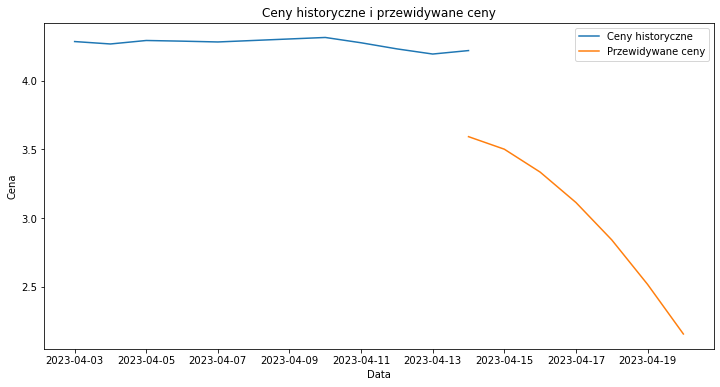

In [113]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Konwertowanie kolumny 'Date' na obiekt datetime
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values(by='Date', ascending=False)

# Wczytanie modelu
model = load_model('model.h5')

# Tworzenie sekwencji czasowych
time_steps = 10
X, y = create_sequences(df2[['Price', 'Open', 'High', 'Low']], df2['Price'], time_steps)

# Przewidywanie cen na kolejne 7 dni
predictions = []
current_sequence = X[-1]
for i in range(7):
    current_sequence = current_sequence.reshape(1, time_steps, 4)
    next_prediction = model.predict(current_sequence)
    last_date = df2['Date'].max()
    next_date = last_date + datetime.timedelta(days=1)
    predictions.append((next_date, next_prediction[0, 0]))
    new_prediction = np.array([[next_prediction[0, 0], 0, 0, 0]]).reshape(1, 1, 4)
    current_sequence = np.concatenate([current_sequence[:, 1:, :], new_prediction], axis=1)

# Odwrócenie skali i przygotowanie danych do wykresu
historical_data = df2.head(time_steps)
historical_data['Price'] = scaler.inverse_transform(historical_data['Price'].values.reshape(-1, 1))
historical_data = historical_data.set_index('Date')
predictions = scaler.inverse_transform(np.array(predictions)[:, 1].reshape(-1, 1))
date_range = pd.date_range(start=df2['Date'].max(), periods=7, freq='D')
predictions_with_dates = pd.DataFrame({'Date': date_range, 'Price': predictions.flatten()})
predictions_with_dates = predictions_with_dates.set_index('Date')

# Wyświetlenie danych na wykresie
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(historical_data['Price'], label='Ceny historyczne')
ax.plot(predictions_with_dates['Price'], label='Przewidywane ceny')
ax.set_xlabel('Data')
ax.set_ylabel('Cena')
ax.set_title('Ceny historyczne i przewidywane ceny')
ax.legend()
plt.show();
